### Group 10
1.   Ho Zhi Yi
2.   Chia Siao Wei
3.   Li Yang
4.   Lim Chooi Yeng
5.   Pang Chong Wen
6.   Tan Jia Xuan
7.   Yeyang Liu

### Notes

Greetings Dr. Norisma,

Here is the [Drive Folder](https://drive.google.com/drive/folders/1HAefWSnH-YiEb8cd39BSR6em7E3ASf9V?usp=sharing) containing sample text files we use to generate the questions for your reference.

Here's the [link](https://drive.google.com/drive/folders/1dWVqnY6IN_Z_fAOEmpNrHpi3UxsTmUk6?usp=sharing) to our infographic poster for quick access.



## Multiple Choice Questions (MCQ) Generator
This project uses Extractive Summarizer, Wordnet and Conceptnet to generate mcq questions and answers from any text article.

In [ ]:
!pip install -q streamlit                               # for buiding web application
!pip install -q gensim                                  # for topic modelling
!pip install -q flashtext                               # for fast keyword extraction from text
!pip install -q pywsd                                   # to provide word sense disambiguation capabilities
!pip install -q nltk                                    # for NLP tasks
!pip install -q git+https://github.com/boudinfl/pke.git # for automatic keyphrase extraction from text
!python -m spacy download en_core_web_sm --quiet

import nltk
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('popular',quiet=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.7 MB/s eta 0:00:00
2023-06-14 03:37:09.166902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimi

True

In [ ]:
%%writefile model.py
import string
import requests
import json
import re
import random
import pprint
import itertools
import pke

from nltk.corpus import stopwords # Stopwords are the words that we need to avoid while considering keyword extraction
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize, sent_tokenize

from flashtext import KeywordProcessor

from pywsd.lesk import simple_lesk


def pre_processing(text):
    # Tokenizing the text
    stopWords = set(stopwords.words("english"))
    words = word_tokenize(text)

    # Creating a frequency table to keep the score of each word
    freqTable = {}
    for word in words:
        word = word.lower()
        # skip the stopwords
        if word in stopWords:
          continue
        if word in freqTable:
          freqTable[word] += 1
        else:
          freqTable[word] = 1


    # Creating a dictionary to keep the score of each sentence
    sentences = sent_tokenize(text)
    sentenceValue = {}

    for sentence in sentences:
        for word, freq in freqTable.items():
            # if word is present in the tokenized text
            if word in sentence.lower():
                if sentence in sentenceValue:
                    # increase sentence score
                    sentenceValue[sentence] += freq
                else:
                    sentenceValue[sentence] = freq
        sentenceValue[sentence] = sentenceValue[sentence] //len(word_tokenize(sentence)) #divide sentence value by the number of words in the sentence so that long sentences wont have advantage

    sumValues = 0
    for sentence in sentenceValue:
        sumValues += sentenceValue[sentence]

    # Average value of a sentence from the original text
    average = int(sumValues / len(sentenceValue))

    # Storing sentences into our summary.
    summary = ''
    for sentence in sentences:
        if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.2 * average) and len(sentence) > 20):
            summary += " " + sentence
    return summary


def get_nouns_multipartite(text):
    out=[]
    # create MultipartiteRank extractor
    extractor = pke.unsupervised.MultipartiteRank()

    stoplist = list(string.punctuation)
    stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-'] #add "(",")","{","{","[","]" to stoplist
    stoplist += pke.lang.stopwords.get('en')

    # load content of document
    extractor.load_document(input=text, stoplist=stoplist)

    # Select longest sequence of nouns and adjective that do not contain punctuation marks or stopwords as candidates.
    pos = {'VERB', 'ADJ', 'NOUN', 'PROPN'}
    extractor.candidate_selection(pos=pos)

    #  build the Multipartite graph and rank candidates using random walk,
    #  alpha controls the weight adjustment mechanism, see TopicRank for
    #  threshold/method parameters.
    extractor.candidate_weighting(alpha=1.1, threshold=0.75, method='average')
    keyphrases = extractor.get_n_best(n=30)

    for key in keyphrases:
        out.append(key[0])

    return out

def tokenize_sentences(text):
    sentences = sent_tokenize(text)
    sentences = [sentence.strip() for sentence in sentences if len(sentence) > 20]
    return sentences

def get_sentences_for_keyword(keywords, sentences):
    keyword_processor = KeywordProcessor()
    # Create a dictionary to store keyword-sentence mappings
    keyword_sentences = dict()
    # Add keywords to the keyword processor and initialize empty sets for each keyword, use set to prevent duplicated sentences
    for word in keywords:
        keyword_sentences[word] = set()
        keyword_processor.add_keyword(word)
    # Iterate over each sentence
    for sentence in sentences:
        # Extract keywords from the sentence
        keywords_found = keyword_processor.extract_keywords(sentence)
        for key in keywords_found:
            keyword_sentences[key].add(sentence)
    # Convert sets to lists and sort the sentences in each keyword list by length in descending order
    for key in keyword_sentences.keys():
        values = list(keyword_sentences[key])
        values = sorted(values, key=len, reverse=True)
        keyword_sentences[key] = values
    return keyword_sentences


def get_distractors_wordnet(syn,word):
    distractors=[]
    word= word.lower()
    orig_word = word
    if len(word.split())>0:
        word = word.replace(" ","_")
    hypernym = syn.hypernyms()
    if len(hypernym) == 0:
        return distractors
    for item in hypernym[0].hyponyms():
        name = item.lemmas()[0].name().lower()
        # print ("name ",name, " word",orig_word)
        if name.replace("_"," ") == orig_word:
            continue
        name = name.replace("_"," ")
        name = " ".join(w.capitalize() for w in name.split())
        if name is not None and name not in distractors:
            distractors.append(name)
    return distractors


def calculate_wup_similarity(sentence, word):
    # Tokenize sentence
    words = word_tokenize(sentence)

    # Get the appropriate sense of the word in the context
    sense = lesk(words, word)

    if sense is not None:
        # Retrieve the sense definitions for the word
        synsets = wn.synsets(word,'n')

        # Calculate WUP similarity for each sense definition
        similarities = [sense.wup_similarity(synset) for synset in synsets]

        # Select the most similar sense
        max_similarity = max(similarities)
        most_similar_sense = synsets[similarities.index(max_similarity)]

        return most_similar_sense
    else:
        return None

def get_wordsense(sent,word):
    word= word.lower()

    if len(word.split())>0:
        word = word.replace(" ","_")


    synsets = wn.synsets(word,'n')
    if synsets:
        wup = calculate_wup_similarity(sent, word)
        simple_lesk_output = simple_lesk(sent, word, pos='n')
        lowest_index = min (synsets.index(wup),synsets.index(simple_lesk_output))
        return synsets[lowest_index]
    else:
        return None

# Distractors from http://conceptnet.io/
def get_distractors_conceptnet(word):
    word = word.lower()
    original_word= word
    if (len(word.split())>0):
        word = word.replace(" ","_")
    distractor_list = []
    url = "http://api.conceptnet.io/query?node=/c/en/%s/n&rel=/r/PartOf&start=/c/en/%s&limit=5"%(word,word)
    obj = requests.get(url).json()

    for edge in obj['edges']:
        link = edge['end']['term']

        url2 = "http://api.conceptnet.io/query?node=%s&rel=/r/PartOf&end=%s&limit=10"%(link,link)
        obj2 = requests.get(url2).json()
        for edge in obj2['edges']:
            word2 = edge['start']['label']
            if word2 not in distractor_list and original_word.lower() not in word2.lower():
                distractor_list.append(word2)

    return distractor_list


def get_mcq(contents):
    contents = pre_processing(contents)
    impWords=get_nouns_multipartite(contents)
    print(impWords)
    sentences = tokenize_sentences(contents)
    print(sentences)
    keyword_sentence_mapping = get_sentences_for_keyword(impWords, sentences)
    print(keyword_sentence_mapping)
    # return keyword_sentence_mapping
    key_distractor_list = {}

    for keyword in keyword_sentence_mapping:
        wordsense = get_wordsense(keyword_sentence_mapping[keyword][0],keyword)
        if wordsense:
            distractors = get_distractors_wordnet(wordsense,keyword)
            if len(distractors) ==0:
                distractors = get_distractors_conceptnet(keyword)
            if len(distractors) != 0:
                key_distractor_list[keyword] = distractors
        else:

            distractors = get_distractors_conceptnet(keyword)
            if len(distractors) != 0:
                key_distractor_list[keyword] = distractors
    output = []
    index = 1
    asked_sentences = set()  # Track the sentences that have been asked

    for each in key_distractor_list:
        sentence = keyword_sentence_mapping[each][0]

        if sentence in asked_sentences:
            continue

        pattern = re.compile(each, re.IGNORECASE)
        question = pattern.sub( " _______ ", sentence)


        # choices = [each.capitalize()] + key_distractor_list[each]
        # top4choices = choices[:4]
        # random.shuffle(top4choices)
        optionchoices = ['a','b','c','d']

        options = [
            {"option": each.capitalize()}
        ] + [{"option": distractor} for distractor in key_distractor_list[each]]
        options = options[:4]
        random.shuffle(options)
        answer = each.capitalize()

        question_data = {
            "id": index,
            "question": question,
            "options": options,
            "answer": answer
        }

        # Print question, option and answer
        print ("%s)"%(index),question)
        for idx,choice in enumerate(options):
            print ("\t",optionchoices[idx],")"," ",choice['option'])
        print("Answer: ", answer, "\n")


        output.append(question_data)
        index += 1

        # Add the sentence to the asked_sentences set
        asked_sentences.add(sentence)
    return output

Writing model.py


In [ ]:
%%writefile demo.py
import streamlit as st
import pandas as pd
import json
from io import StringIO
from model import get_mcq

CORRECT_FLAG = "<span style='color:green; font-size: 20px;'>Correct!</span>"
INCORRECT_FLAG = "<span style='color:red; font-size: 20px;'>Incorrect!</span>"

@st.cache_data
def load_txt_mcq(content):
	return get_mcq(content)

def clear_states():
	for n in st.session_state:
		if 'radio-' in n or 'checked-' in n or 'selected-' in n:
			del st.session_state[n]

# Left Sidebar
with st.sidebar:
	# ----------- Upload File -----------
	st.markdown("### Upload Your File: ")
	col1, col2 = st.columns(2)
	with col1:
		json_file = st.file_uploader(
			"**Choose a JSON file** (Load mcq Question)",
			accept_multiple_files=False,
			key="json_file"
			)
		if json_file:
			st.session_state.mcq_file = json.load(json_file)
			st.session_state.is_json = True
		else:
			st.session_state.is_json = False

	with col2:
		txt_file = st.file_uploader(
			"**Choose a TXT file** (Gen mcq Question)",
			accept_multiple_files=False,
			key="text_file"
		)
		if txt_file:
			content = StringIO(txt_file.getvalue().decode("utf-8")).read()
			st.session_state.mcq_file = load_txt_mcq(content)
			st.session_state.is_txt = True
		else:
			st.session_state.is_txt = False

	col3, col4 = st.columns(2)
	if not (json_file or txt_file):
		st.write("**Please choose a file first.**")

	with col3:
		if st.session_state.get('mcq_file'):
			if st.button("Generate MCQs", key='gen_mcq_btn'):
				st.session_state['gen_mcq'] = True
	with col4:
		if st.session_state.get('mcq_file'):
			if st.session_state.get("gen_mcq", None):
				st.download_button(
				    label="Download MCQs",
				    data=json.dumps(st.session_state.mcq_file),
				    file_name='mcq.json',
				    mime='text/json',
				)
	# st.session_state


def readme_block():
	members = ["Ho Zhi Yi", "Chia Siao Wei", "Li Yang",
		"Lim Chooi Yeng","Pang Chong Wen","Tan Jia Xuan","Yeyang Liu"]
	st.markdown("<p style='text-align: center;'>WID 3002 - Natural Language Processing (Group 10)</p>", unsafe_allow_html=True)

	for member in members:
		st.markdown(f"<p style='text-align: center;'>{member}</p>", unsafe_allow_html=True)



def mcq_block(mcq_file):
	st.write("")

	st.session_state.mcq_block = True
	mcqs = st.session_state.mcq_file
	for i, q in enumerate(mcqs):
		st.markdown(f"### **Question {i+1}**")
		# for part in q['question'].split('\r\n'):
				# if part.strip() != '':
						# st.markdown(f"#### {part}")
		question_body = q['question'].replace('\r\n', ' ')
		st.markdown(f"#### {question_body}")
		st.radio(
			f"{q['question']}",
			[o['option'] for o in q['options']],
			key=f"radio-{i}",
			label_visibility="collapsed"
		)
		# just for debugging, comment this if no need for correct answer
		# st.write(q.get("answer"))
		if st.button("Check", key=f"check_button_{i}"):
			st.session_state[f"checked-{i}"] = True
			selected = st.session_state[f"radio-{i}"]
			st.session_state[f"selected-{i}"] = selected

		if st.session_state.get(f"checked-{i}"):
			if st.session_state[f"selected-{i}"] == q.get("answer"):
			    st.markdown(CORRECT_FLAG, unsafe_allow_html=True)
			else:
				st.markdown(INCORRECT_FLAG, unsafe_allow_html=True)
		st.write("")

# Main Page
st.markdown("<h1 style='text-align: center;'>NLP MCQ Generator</h1>", unsafe_allow_html=True)

if (st.session_state.get('is_txt') or st.session_state.get('is_json')) and st.session_state.get('gen_mcq'):

	mcq_block(st.session_state.mcq_file)
	# if st.session_state.get('mcq_block'):
	# 	st.button("Submit")

else:
	readme_block()
	clear_states()

Writing demo.py


## Interface

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.951s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
!streamlit run demo.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 3.694s
your url is: https://twelve-women-flow.loca.lt


- Click the above url
- Open the file logs.txt
- Paste the external url to the open page (no prefix or port number)

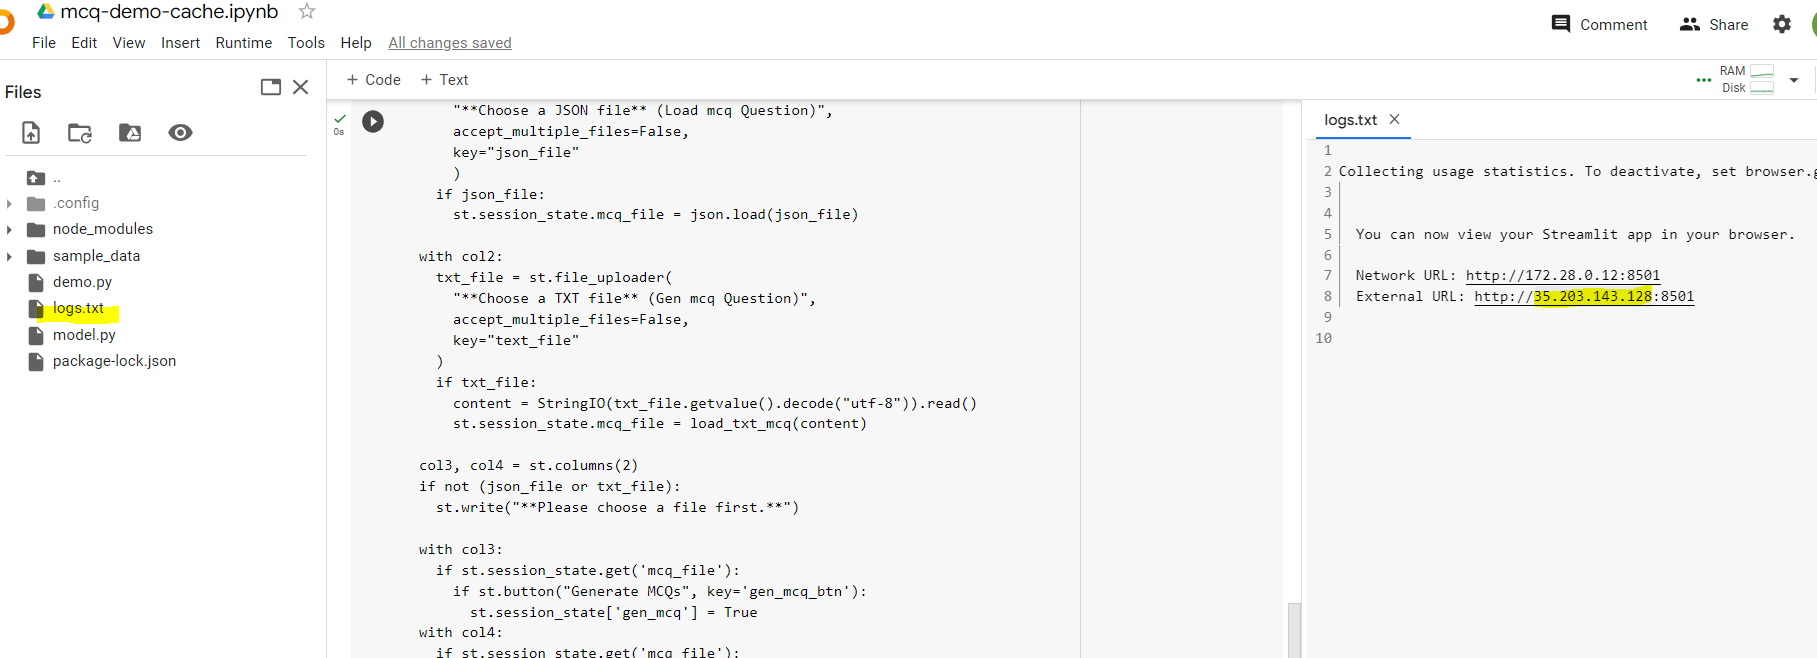